In [1]:
#CCN for binary image classifier (peak's existance or not)

import scipy.io
from scipy.sparse import coo_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np

from sys import getsizeof

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from MyDataset import MyDataset
import random

from statsmodels.stats.proportion import proportion_confint

print(torch.__version__)

1.12.1


In [2]:
torch.set_default_dtype(torch.float64)

images = torch.load('images.pt')
labels = torch.load('labels.pt')

In [3]:
# number of epochs to train the model
n_epochs = 1
# Learning rate of optimizer
learning_rate = 0.001
# Batch size of data loaders and batch size used when training model
batch_size = 16
#dropout rate
dropout = 0.5

In [5]:
print(len(images))
print(len(labels))

random.Random(10).shuffle(images) # shuffling with seed
random.Random(10).shuffle(labels) 

images=images[100:600]
labels=labels[100:600]

size = len(images)

dataset = MyDataset(images,labels)

split_indices = list(range(0,size))

train_idx=split_indices[0:round(0.70*size)]
val_idx=split_indices[round(0.70*size):round(0.85*size)]
test_idx=split_indices[round(0.85*size):]
print(train_idx)
print(val_idx)
print(test_idx)

train_dataset=MyDataset([images[i] for i in train_idx],[labels[i] for i in train_idx])
val_dataset=MyDataset([images[i] for i in val_idx],[labels[i] for i in val_idx])
test_dataset=MyDataset([images[i] for i in test_idx],[labels[i] for i in test_idx])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    

9786
9786
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [6]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 13000x560x1 "image" tensor)
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv1_bn=nn.BatchNorm2d(4)
        # convolutional layer (sees 1625x140x4 tensor)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv2_bn=nn.BatchNorm2d(8)
        # convolutional layer (sees 203x35x8 tensor)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3_bn=nn.BatchNorm2d(16)
        # max pooling layers
        self.pool_1 = nn.MaxPool2d(2, [8,4])
        #self.pool_2 = nn.MaxPool2d(2, [2,2])
        # linear layer (X -> 10)
        self.fc1 = nn.Linear(16 * 26 * 9, 10)
        # linear layer (10 -> 1)
        self.fc2 = nn.Linear(10, 1)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        #print(x.shape)
        x = self.pool_1(F.relu(self.conv1_bn(self.conv1(x))))
        #print(x.shape)
        x = self.pool_1(F.relu(self.conv2_bn(self.conv2(x))))
        #print(x.shape)
        x = self.pool_1(F.relu(self.conv3_bn(self.conv3(x))))
        #print(x.shape)
        # flatten image input
        x = x.view(-1, 16 * 26 * 9)
        #print(x.shape)
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # add dropout layer
        x = self.dropout(x)
        # output
        x = torch.sigmoid(self.fc2(x))
        x = x.view(x.size(0))
        #print(x.shape)    
        return x          

In [7]:
# create a complete CNN
torch.manual_seed(10) # set seed before creating model
model = Net()
        
print(model.state_dict()['fc1.weight'])

print(model)
    
# specify loss function (Binary cross entropy)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

tensor([[-0.0046,  0.0138, -0.0149,  ..., -0.0086, -0.0022,  0.0009],
        [ 0.0089, -0.0095,  0.0039,  ...,  0.0001, -0.0048, -0.0012],
        [ 0.0144,  0.0070, -0.0052,  ...,  0.0129,  0.0139,  0.0153],
        ...,
        [ 0.0134, -0.0108,  0.0029,  ..., -0.0079, -0.0066,  0.0070],
        [ 0.0118, -0.0110, -0.0095,  ..., -0.0056,  0.0061,  0.0022],
        [-0.0038, -0.0039,  0.0158,  ..., -0.0145, -0.0109,  0.0134]])
Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=[8, 4], pad

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    model.cuda()
    criterion.cuda()
    print('CUDA is available!  Training on GPU ...')

valid_loss_min = np.Inf # track change in validation loss

train_loss= [0.0] * n_epochs
valid_loss= [0.0] * n_epochs

for epoch in range(0, n_epochs):

    # keep track of training and validation loss
    #train_loss[epoch] = 0.0
    #valid_loss[epoch] = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        data=data.to_dense() # model needs dense matrices as input
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        output = output.to(torch.float64) #
        target = target.to(torch.float64) #
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[epoch] += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        data=data.to_dense() # model needs dense matrices as input
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        output = output.to(torch.float64) #
        target = target.to(torch.float64) #
        print(output)
        print(target)
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss[epoch] += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss[epoch] = train_loss[epoch]/len(train_loader.sampler)
    valid_loss[epoch] = valid_loss[epoch]/len(valid_loader.sampler)
        
    # print training/validation statistics
    print_train_loss=train_loss[epoch]
    print_valid_loss=valid_loss[epoch]
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, print_train_loss, print_valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss[epoch] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        print_valid_loss))
        torch.save(model.state_dict(), 'my_model.pt')
        valid_loss_min = valid_loss[epoch]

CUDA is available!  Training on GPU ...
tensor([0.5123, 0.4854, 0.4804, 0.4775, 0.4901, 0.4776, 0.4856, 0.4875, 0.4806,
        0.4833, 0.4884, 0.4576, 0.4918, 0.4697, 0.4837, 0.4997],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       device='cuda:0')
tensor([0.4833, 0.4794, 0.4866, 0.4848, 0.4824, 0.4919, 0.4788, 0.4984, 0.4767,
        0.4761, 0.4853, 0.4722, 0.4805, 0.4884, 0.4923, 0.5006],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       device='cuda:0')
tensor([0.4780, 0.4767, 0.4866, 0.4851, 0.4840, 0.4888, 0.4845, 0.4666, 0.4861,
        0.4923, 0.4849, 0.4776, 0.4692, 0.4901, 0.4870, 0.4777],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0.4884, 0.4830, 0.4724, 0.4833, 0.4900, 0.4750, 0.4762, 0.4720, 0.4860,
       

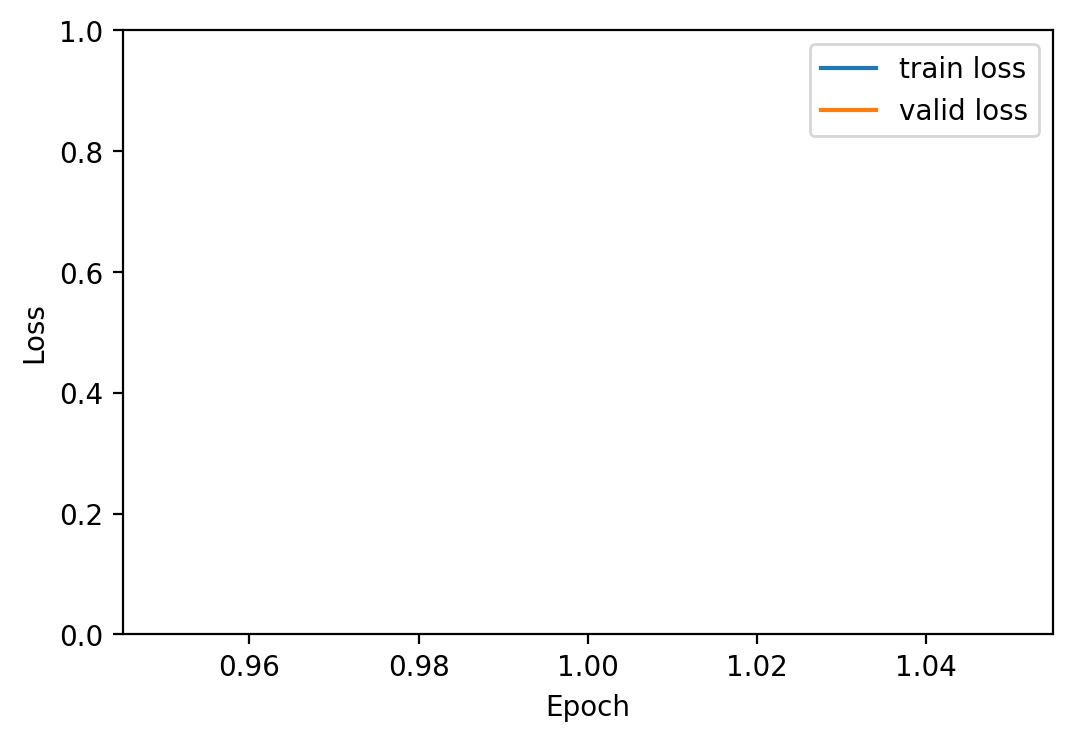

In [9]:
fig, ax = plt.subplots()
fig.set_dpi(200)
plt.ylim(0,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
line1 = plt.plot(np.linspace(1, n_epochs, num=n_epochs), train_loss)
line2 = plt.plot(np.linspace(1, n_epochs, num=n_epochs), valid_loss)
plt.legend(["train loss", "valid loss"])
#plt.xticks(np.arange(0, n_epochs, 1))

In [10]:
model = Net()
model.load_state_dict(torch.load('my_model.pt'))
model.eval()


#if train_on_gpu:
#model.cuda()

total = 0
true_positive = 0
true_negative = 0


for data, target in test_loader:
        data=data.to_dense() # model needs dense matrices as input
        # move tensors to GPU if CUDA is available
        #if train_on_gpu:
        #    data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        output = output.to(torch.float64) #
        target = target.to(torch.float64) #
        print(output)
        print(target)
        
        for i in range(len(output)):
            if (target[i] == 1) and (output[i] >= 0.5):
                true_positive += 1
            if (target[i] == 0) and (output[i] < 0.5):
                true_negative += 1
            total +=1
            
p_95 = proportion_confint((true_positive+true_negative), total, 0.05, 'normal')
accuracy = (true_positive + true_negative)/total
print('Accuracy:' + str(accuracy) + str(p_95))                
                

tensor([0.4832, 0.4897, 0.4565, 0.4891, 0.4808, 0.4831, 0.4813, 0.4775, 0.4869,
        0.4708, 0.4828, 0.4702, 0.4842, 0.4889, 0.5055, 0.4795],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.])
tensor([0.4891, 0.4755, 0.4867, 0.4937, 0.4865, 0.4874, 0.4814, 0.4793, 0.4819,
        0.4811, 0.4821, 0.4876, 0.4761, 0.4996, 0.4964, 0.4973],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([0.4839, 0.4855, 0.4664, 0.4759, 0.4798, 0.4828, 0.4926, 0.4786, 0.4869,
        0.5002, 0.4970, 0.4867, 0.5091, 0.4870, 0.5104, 0.4799],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])
tensor([0.4728, 0.4884, 0.4749, 0.4808, 0.4844, 0.4732, 0.4869, 0.4884, 0.4849,
        0.4656, 0.4892, 0.4893, 0.4828, 0.4662, 0.4859, 0.4759],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])
